
<p style="text-align: center;"><font size=6>Курсовая работа<Big></font>
    
<p style="text-align: center;"><font size=5>Оценка ошибок самонаведения ракеты на маневрирующую цель.<Big></font>
<p style="text-align: center;"><font size=3><i>Хромов Алексей 715а гр.<i><Big></font>



































##  Постановка задачи.
Работа выполняется методом математичесского моделирования


In [1]:
# standard imports\n",
import os
import random
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.6

PI = math.pi

Для начала рассмотрим передаточные функции и дифференциальные уравнения, которым они соотвествуют. Интегрирующее звено

$$W_\text{кин}(s)=\frac{1}{s}\qquad\Rightarrow\qquad 
\frac{dU_{out}(t)}{dt}=U_{in}(t)\qquad\Rightarrow\qquad 
U_{out}(t)=\int\limits_0^tU_{int}(\tau)\,d\tau;$$

тогда для

$$W_\text{кин}(s)=\frac{1}{s^2}\qquad\Rightarrow\qquad 
\frac{d^2U_{out}(t)}{dt^2}=U_{in}(t)\qquad\Rightarrow\qquad 
U_{out}(t)=\int\limits_0^t\int\limits_0^{\tau_2}U_{int}(\tau_1)\,d\tau_1\,d\tau_2.$$

Форсирующее звено:

$$W_\text{фор}(s)=\frac{(1+\tau s)}{\tau D}\qquad\Rightarrow\qquad 
U_{out}(t)=\left(U_{int}(t)+\frac{dU_{int}(t)}{dt}\right)/(\tau D).
$$

Контур углового сопровождения:

$$d=\frac{\Delta\omega_0}{\Delta\theta}=\frac{U_{out}(t)}{U_{int}(t)}\qquad\Rightarrow\qquad U_{out}(t)=U_{int}(t)\cdot d$$


In [2]:
def signal_Wy(t, dt):
    N = 7
    if t<=0.1:
        sig = 10*N
    else:
        sig = 10*N
    return sig

In [3]:
def initial_conditions():
    y_target = 0
    y_rocket = 0
    speed_target = 0
    speed_rocket = 0
    phi = 0
    alpha = 0
    lambd0 = 0
    return y_target, y_rocket, speed_target, speed_rocket, phi, alpha, lambd0

In [4]:
'''
        integrator
'''
def integrator(sum_out, sum_in, dt):
    sum_out += sum_in * dt
    return sum_out

In [5]:
'''
        (1 + tau * s)/(tau * D)
'''
def operator_tau_D(h, dh_dt, t):
    tau0 = 10 # время до втсречи с ракетой
    V0=1500
    D = V0*(tau-t) # дальность между ракетой и целью
    w = (h + (tau-t) * dh_dt)/((tau-t) * D)
    return w


In [6]:
def sampling(signal, t):
    T = 0.1
    if (t*10) % (T*10) == 0:
        signal_samp = signal
    else:
        signal_samp = 0
        
    return signal_samp, T

In [7]:
'''
def corner_tracking(signal):
    d = 5
    return signal*d
'''
def corner_tracking(signal, d):
    w = d*signal
    return w

In [8]:
def extrapolator(signal_samp, signal_buf, t, dt, T):
    if ((t-dt)*10) % (T*10) == 0:
        signal = signal_samp
        signal_buf = signal_samp
    else:
        signal = signal_buf
        
    return signal, signal_buf

In [9]:
def modul_T(phi, alpha, d, t_i):
    
    delta_alpha = 0#random.normalvariate(0, 0.1)
        
    delta = phi - alpha + delta_alpha
        
    delta_sampl, T = sampling(delta, t_i)
    
    return delta_sampl, T

In [10]:
def gyrostabilizer(alpha, w_0, w_0_buf, dt, t, T):
    
    w_0_ext, w_0_buf = extrapolator(w_0, w_0_buf, t, dt, T)
    alpha = integrator(alpha, w_0_ext, dt)
    
    return alpha, w_0_buf

In [11]:
def module_Z_F(dw0, lambd_prev, T, T2, n):
    V0 = 1500

    return (n*V0*dw0 + T2/T*lambd_prev) / (1 + T2/T)
    
    

In [12]:
def module_Z(w0, w0_prev, lambd_prev, T, T2, n):
    dw0 = (w0 - w0_prev)/T
    lambd = lambd_prev + T * module_Z_F(dw0, lambd_prev, T, T2, n)
    
    return lambd

In [13]:
def nolinear(lambd):
    L=200
    lambd*=1
    if lambd > L:
        lambd = L
        
    if lambd < -L:
        lambd = -L
        
    return lambd

In [14]:
def board_digital_computer(delta_sampl, t, T, lambd_prev, w0_prev, d, T2, n):
    
    w0 = corner_tracking(delta_sampl, d)#+random.normalvariate(0, 0.1)
    
    lambd = module_Z(w0, w0_prev, lambd_prev, T, T2, n)
    lambd0 = nolinear(lambd)
    
    
    return lambd0, w0, lambd

In [15]:
def stabilization_loop_S_F(lambd0, Wr, dWr):
    
    ksi = 0.7
    Tk=0.2
    
    return (lambd0 - Wr - 2*ksi*Tk*dWr)/(Tk**2)

In [16]:
def stabilization_loop_S(lambd0, Wr, dot_Wr, dt):
    
    #predict
    dot_Wr_next = dot_Wr + dt * stabilization_loop_S_F(lambd0, Wr, dot_Wr)
    
    Wr_next = Wr + dt * dot_Wr_next
    
    #correction
    dot_Wr_next = dot_Wr + dt * (stabilization_loop_S_F(lambd0, Wr, dot_Wr) + stabilization_loop_S_F(lambd0, Wr_next, dot_Wr_next))/2
    
    Wr_next = Wr + dt * dot_Wr_next
    
    
    
    return Wr_next, dot_Wr_next

In [17]:
def stabilization_loop(lambd0, lambd0_buf, Wr, dot_Wr, dt, t, T):
    
    lambd0, lambd0_buf = extrapolator(lambd0, lambd0_buf, t, dt, T)
    
    Wr_next, dot_Wr_next = stabilization_loop_S(lambd0, Wr, dot_Wr, dt)
    
    
    return Wr_next, lambd0_buf, dot_Wr_next

In [21]:
def schematic_model(t, d, T2, n):
    
    data_out0 = []
    data_out1 = []
    data_out2 = []
    data_out3 = []
    data_out4 = []
    data_out5 = []
    data_out6 = []
    data_out7 = []
    data_time = []
    
    t_scale = 1000
    
    y_target = 0
    speed_target = 0
    
    SUM_y_rocket=0
    SUM_speed_rocket=0
    SUM_Wr=0
    SUM_alpha=0
    SUM_lambd_prev=0
    SUM_w0=0
    SUM_w0_buf=0
    SUM_lambd0_buf=0
    SUM_dot_Wr=0
    SUM_phi = 0
    
    SUM_y_rocket0=0
    SUM_speed_rocket0=0
    SUM_Wr0=0
    SUM_alpha0=0
    SUM_lambd_prev0=0
    SUM_w00=0
    SUM_w0_buf0=0
    SUM_lambd0_buf0=0
    SUM_dot_Wr0=0
    SUM_phi0 = 0
    
    
    averag = 1
     
    for i in range(t*t_scale):
        t_i = i/t_scale
        dt_i = 1/t_scale
        
        Wy = signal_Wy(t_i, dt_i)
        
        '''
            integrator
        '''
        speed_target = integrator(speed_target, Wy, dt_i)
        y_target = integrator(y_target, speed_target, dt_i)
        
        SIGMA = []
        for j in range(averag):
            
            phi=SUM_phi0
            y_rocket=SUM_y_rocket0
            speed_rocket=SUM_speed_rocket0
            Wr=SUM_Wr0
            alpha=SUM_alpha0
            lambd_prev=SUM_lambd_prev0
            w0=SUM_w00
            w0_buf = SUM_w0_buf0
            lambd0_buf = SUM_lambd0_buf0
            dot_Wr = SUM_dot_Wr0
            
            h = y_target - y_rocket
        
            w = operator_tau_D(h, speed_target - speed_rocket, t_i)
            print
        
        
            '''
                integrator
            '''
            phi = integrator(phi, w, dt_i)
        
            delta_sampl, T = modul_T(phi, alpha, d, t_i)
            
        
            if (t_i*10) % (T*10) == 0:
                lambd0, w0, lambd_prev = board_digital_computer(delta_sampl, t_i, T, lambd_prev, w0, d, T2, n)
                
            
            alpha, w0_buf = gyrostabilizer(alpha, w0, w0_buf, dt_i, t_i, T)
        
            Wr, lambd0_buf, dot_Wr = stabilization_loop(lambd0, lambd0_buf, Wr, dot_Wr, dt_i, t_i, T)
            #print(Wr, j)
        
            '''
            integrator
            '''
            speed_rocket = integrator(speed_rocket, Wr, dt_i)
            y_rocket = integrator(y_rocket, speed_rocket, dt_i)
            
            SIGMA.append(y_rocket)
            
            SUM_y_rocket+=y_rocket
            SUM_speed_rocket+=speed_rocket
            SUM_Wr+=Wr
            SUM_alpha+=alpha
            SUM_lambd_prev+=lambd_prev
            SUM_w0+=w0
            SUM_w0_buf+=w0_buf
            SUM_lambd0_buf+=lambd0_buf
            SUM_dot_Wr+=dot_Wr
            SUM_phi+=phi
            
        SUM_y_rocket0=SUM_y_rocket/averag
        SUM_speed_rocket0=SUM_speed_rocket/averag
        SUM_Wr0=SUM_Wr/averag
        SUM_alpha0=SUM_alpha/averag
        SUM_lambd_prev0=SUM_lambd_prev/averag
        SUM_w00=SUM_w0/averag
        SUM_w0_buf0=SUM_w0_buf/averag
        SUM_lambd0_buf0=SUM_lambd0_buf/averag
        SUM_dot_Wr0=SUM_dot_Wr/averag
        SUM_phi0=SUM_phi/averag
        
        SUM_y_rocket=0
        SUM_speed_rocket=0
        SUM_Wr=0
        SUM_alpha=0
        SUM_lambd_prev=0
        SUM_w0=0
        SUM_w0_buf=0
        SUM_lambd0_buf=0
        SUM_dot_Wr=0
        SUM_phi=0
        
        SUM_sigma = 0
        #print(SIGMA, SUM_y_rocket0)
        for i in SIGMA:
            SUM_sigma+=(i - SUM_y_rocket0)**2
        SUM_sigma/=averag
        
        
        data_out0.append(y_target-SUM_y_rocket0)
        data_out1.append(np.sqrt(SUM_sigma))
        data_out2.append(y_target)
        data_out3.append(SUM_y_rocket0)
        data_out4.append(speed_target)
        data_out5.append(SUM_speed_rocket0)
        data_out6.append(Wy)
        data_out7.append(SUM_Wr0)
        data_time.append(t-t_i)
        
    return data_out0, data_out1, data_out2, data_out3, data_out4, data_out5, data_out6, data_out7, data_time
        

2.1891211785223277
0.0


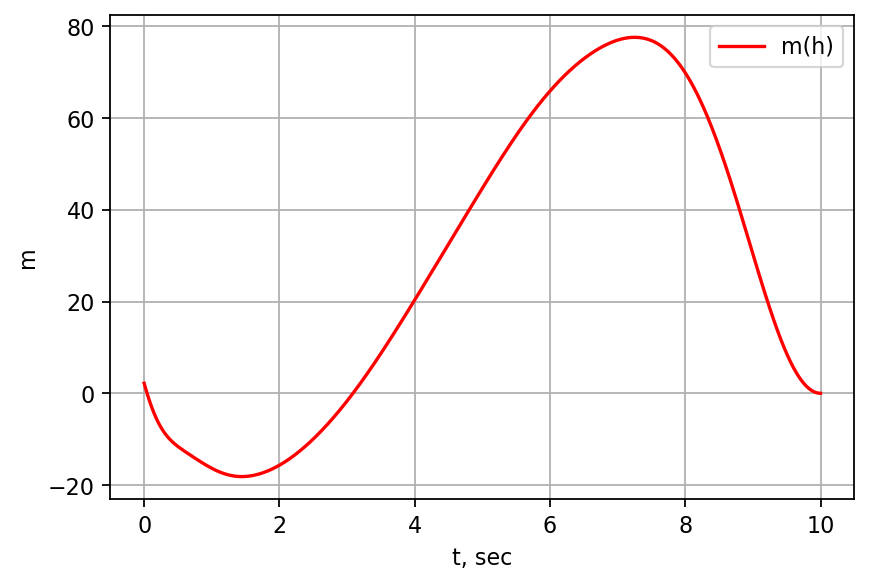

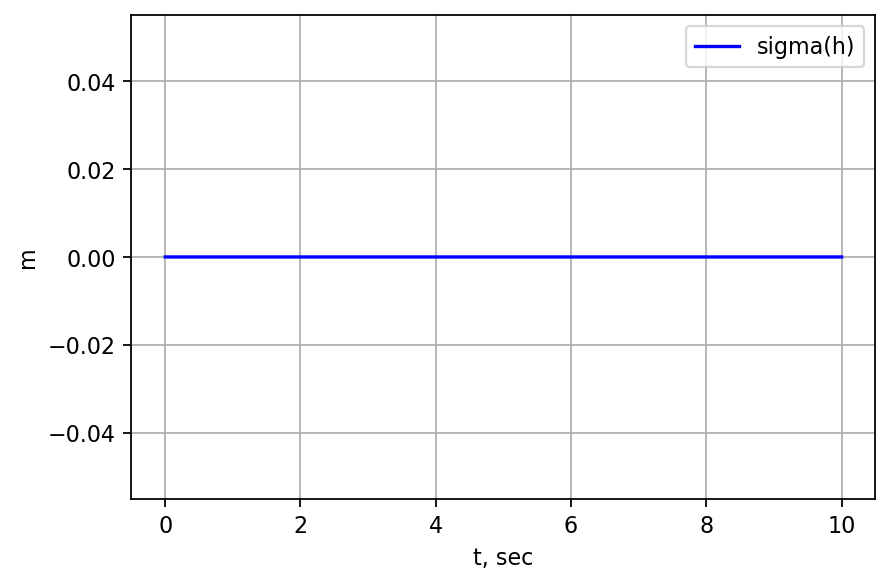

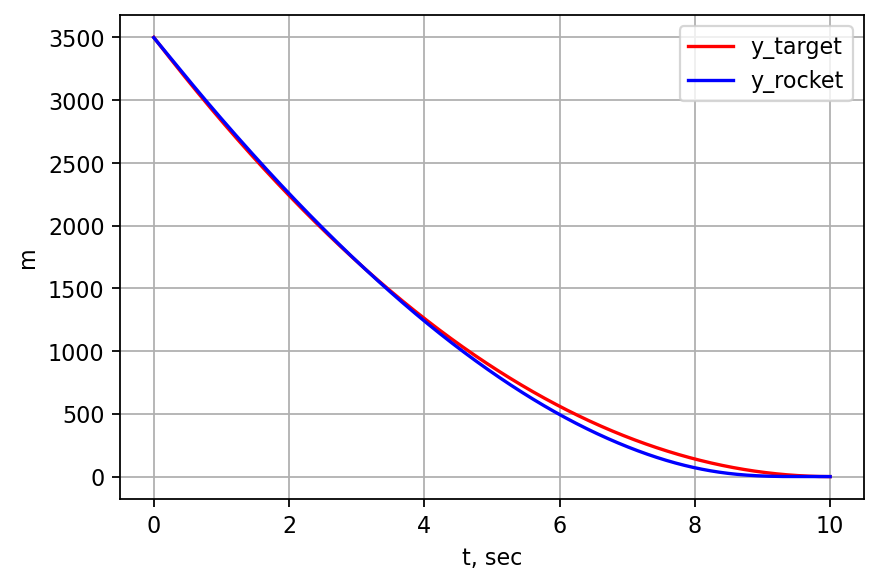

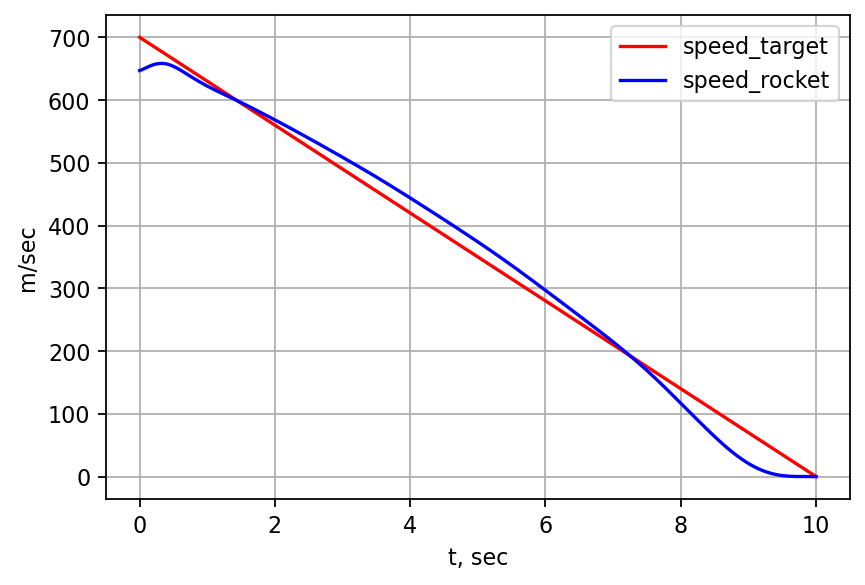

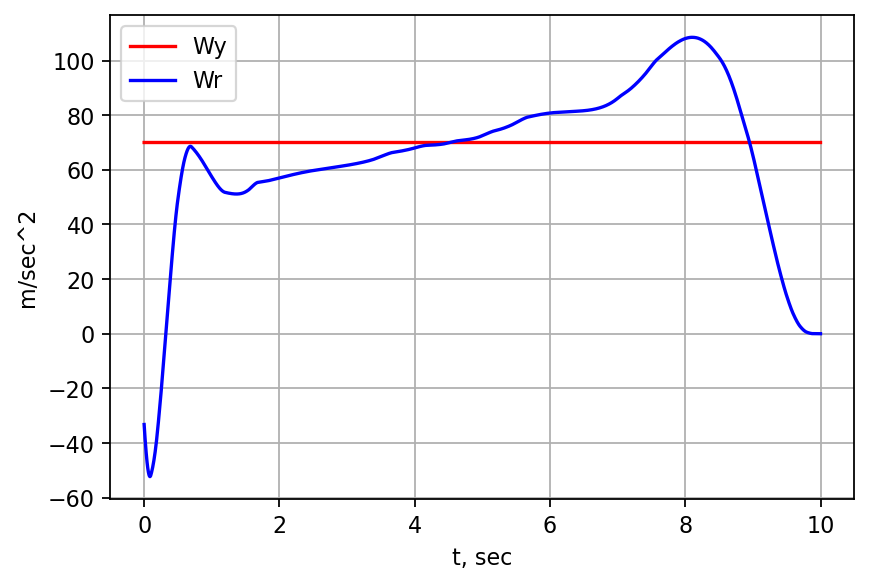

In [20]:
tau = 10 #10 sec
d = 10#5
T2 = 0.04#0.0001
n = 20#20
data_U0, data_U1, data_U2, data_U3, data_U4, data_U5, data_U6, data_U7,  data_time = schematic_model(tau, d, T2, n)
print(data_U0[-1])
print(data_U1[-1])



plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, data_U0, label = u'm(h)', color = 'r')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, data_U1, label = u'sigma(h)', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, data_U2, label = u'y_target', color = 'r')
plt.plot(data_time, data_U3, label = u'y_rocket', color = 'b')
plt.legend()
plt.grid(True)
plt.show()


plt.ylabel('m/sec')
plt.xlabel('t, sec')
plt.plot(data_time, data_U4, label = u'speed_target', color = 'r')
plt.plot(data_time, data_U5, label = u'speed_rocket', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('m/sec^2')
plt.xlabel('t, sec')
plt.plot(data_time, data_U6, label = u'Wy', color = 'r')
plt.plot(data_time, data_U7, label = u'Wr', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

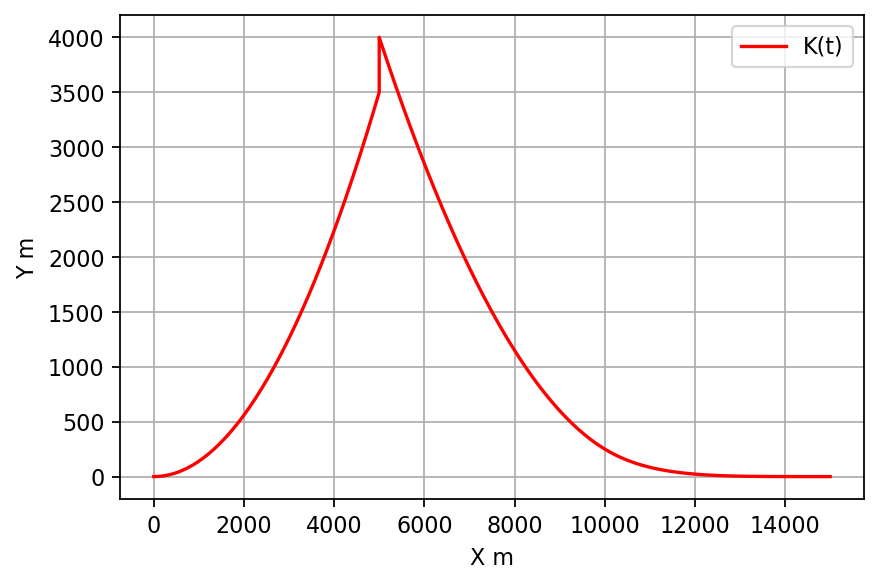

In [46]:
data_coord = []
SS = 0
for t_i in range(tau*1000):
    t_i/=1000
    Vy=500
    SS=Vy*t_i
    data_coord.append(Vy*t_i)
    
data_U = data_U2.copy()

for t_i in range(tau*1000):
    data_U.append(data_U3[tau*1000 - t_i - 1])
    t_i/=1000
    Vr=1000
    data_coord.append(SS+Vr*t_i)
    
    
    
    
    
plt.ylabel('Y m')
plt.xlabel('X m')
plt.plot(data_coord, data_U, label = u'K(t)', color = 'r')
plt.legend()
plt.grid(True)
plt.show()